<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/04_SpeechTimeSeries/examples/video_classification_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Classification with RNN

This notebook demonstrates video classification of action videos using a time-distributed CNN + RNN.

The CNN will use the InceptionV3 model (transfer learning) to perform feature extraction.

1. Run on Colab
2. Runtime -> Change Runtime Type: GPU

We will be using a subset of techniques demonstrated in the more complex example here: https://github.com/harvitronix/five-video-classification-methods

We will also be using a small dataset to demonstrate how this works. Only 5 classes were selected from the UCF101 video classification dataset.

Incidentally, this entire dataset is also part of Tensorflow (but already preprocessed): https://www.tensorflow.org/datasets/catalog/ucf101. The goal of doing this manually is to demonstrate how to go about processing your own video dataset.


In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# Ensure that ffmpeg is installed as we will be using it to extract frames
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

sns.set_style('whitegrid')
%matplotlib inline

## Download video data

We will download the data from github and create a folder structure like this:

```
train/
  Archery/
  Basketball/
  ...
test/
  Archery/
  Basketball/
  ...
```

In [56]:
# Instead of 101 classes, we will start small, just 5 classes.

classes = [
  'Archery',
  'Basketball',
  'BasketballDunk',
  'CricketBowling',
  'CricketShot',
]

classes

['Archery', 'Basketball', 'BasketballDunk', 'CricketBowling', 'CricketShot']

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=89025d17a408b62f5a405f00e7aa2ca6ed957bb10ac95b081d482a56ddc38a2b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
# Download subset of the dataset for the classes we have.
import wget
import zipfile
import os

def download_and_extract(label, folder):
  url = f'https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/{folder}/{label}.zip'
  print(f'Downloaded {url}')

  # prepare folders
  if not os.path.isdir(folder):
    os.mkdir(folder)
  filename = f'{label}.zip'

  # download
  wget.download(url, filename)

  # extract within folder
  with zipfile.ZipFile(filename) as f:
    f.extractall(folder)
  print(f'Extracted {os.path.join(folder, label)}')
  
  # delete zip archive
  os.remove(filename)

In [58]:
for label in classes:
  download_and_extract(label, 'train')
  download_and_extract(label, 'test')

Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/train/Archery.zip
Extracted train/Archery
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/test/Archery.zip
Extracted test/Archery
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/train/Basketball.zip
Extracted train/Basketball
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/test/Basketball.zip
Extracted test/Basketball
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/train/BasketballDunk.zip
Extracted train/BasketballDunk
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/test/BasketballDunk.zip
Extracted test/BasketballDunk
Downloaded https://github.com/lisaong/mldds-courseware/raw/master/data/ucf101-5classes/train/CricketBowling.zip
Extracted train/CricketBowling
Downloaded https://github.com/lisaong/mldds-cours

In [0]:
# Files are downloaded, press 'Refresh' in the Files tab to see them

## Extracting frames from videos

In this step, we will use ffmpeg to extract frames from the video files and save the frames into images. 

This will also generate a csv file describing the class, video filename, and number of frames for each video.

This can take a while to run.

In [0]:
# https://github.com/harvitronix/five-video-classification-methods/blob/master/data/2_extract_files.py
import glob
import csv
from subprocess import call

def get_nb_frames_for_video(video_parts):
    """Given video parts of an (assumed) already extracted video, return
    the number of frames that were extracted."""
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(os.path.join(train_or_test, classname,
                                filename_no_ext + '*.jpg'))
    return len(generated_files)

def get_video_path_parts(video_path):
    """Given a full path to a video, return its parts."""
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

def check_already_extracted(video_parts):
    """Check to see if we created the -0001 frame of this file."""
    train_or_test, classname, filename_no_ext, _ = video_parts
    return bool(os.path.exists(os.path.join(train_or_test, classname,
                               filename_no_ext + '-0001.jpg')))

def extract_files():
    """After we have all of our videos split between train and test, and
    all nested within folders representing their classes, we need to
    make a data file that we can reference when training our RNN(s).
    
    This will let us keep track of image sequences and other parts
    of the training process.
    
    We'll first need to extract images from each of the videos. We'll
    need to record the following data in the file:
    [train|test], class, filename, nb frames
    
    Extracting can be done with ffmpeg:
    `ffmpeg -i video.mpg image-%04d.jpg`
    """

    data_file = []
    folders = ['train', 'test']
    for folder in folders:
      class_folders = glob.glob(os.path.join(folder, '*'))
      
      for vid_class in class_folders:
        class_files = glob.glob(os.path.join(vid_class, '*.avi'))
        
        for video_path in class_files:
          # Get the parts of the file path
          video_parts  = get_video_path_parts(video_path)
          train_or_test, classname, filename_no_ext, filename = video_parts          

          # Only extract if we haven't done it yet. Otherwise, just get
          # the info.
          if not check_already_extracted(video_parts):
            # Now extract it.
            src = os.path.join(train_or_test, classname, filename)
            dest = os.path.join(train_or_test, classname,
                                filename_no_ext + '-%04d.jpg')
            call(["ffmpeg", "-i", src, dest])

            # Now get how many frames it is.
            nb_frames = get_nb_frames_for_video(video_parts)

            data_file.append([train_or_test, classname, filename_no_ext, nb_frames])

            print("Generated %d frames for %s" % (nb_frames, filename_no_ext))

    with open('data_file.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerows(data_file)

    print("Extracted and wrote %d video files." % (len(data_file)))

In [60]:
# If you have many more files, recommend run directly from a Terminal
# (outside of Jupyter or Colab - because Colab can hang)
extract_files()

Generated 46 frames for v_CricketShot_g21_c01
Generated 62 frames for v_CricketShot_g18_c01
Generated 92 frames for v_CricketShot_g15_c02
Generated 100 frames for v_CricketShot_g12_c05
Generated 87 frames for v_CricketShot_g24_c04
Generated 170 frames for v_CricketShot_g22_c01
Generated 68 frames for v_CricketShot_g08_c04
Generated 95 frames for v_CricketShot_g17_c05
Generated 183 frames for v_CricketShot_g22_c05
Generated 87 frames for v_CricketShot_g19_c05
Generated 90 frames for v_CricketShot_g17_c04
Generated 96 frames for v_CricketShot_g11_c05
Generated 77 frames for v_CricketShot_g18_c05
Generated 74 frames for v_CricketShot_g09_c04
Generated 133 frames for v_CricketShot_g20_c01
Generated 82 frames for v_CricketShot_g08_c06
Generated 100 frames for v_CricketShot_g16_c02
Generated 184 frames for v_CricketShot_g22_c02
Generated 134 frames for v_CricketShot_g11_c07
Generated 90 frames for v_CricketShot_g25_c07
Generated 72 frames for v_CricketShot_g25_c04
Generated 76 frames for v_C

In [61]:
# To see what gets generated (if Files Refresh does not show anything)
!ls test/Archery

v_Archery_g01_c01-0001.jpg  v_Archery_g04_c03-0130.jpg
v_Archery_g01_c01-0002.jpg  v_Archery_g04_c03-0131.jpg
v_Archery_g01_c01-0003.jpg  v_Archery_g04_c03-0132.jpg
v_Archery_g01_c01-0004.jpg  v_Archery_g04_c03-0133.jpg
v_Archery_g01_c01-0005.jpg  v_Archery_g04_c03-0134.jpg
v_Archery_g01_c01-0006.jpg  v_Archery_g04_c03-0135.jpg
v_Archery_g01_c01-0007.jpg  v_Archery_g04_c03-0136.jpg
v_Archery_g01_c01-0008.jpg  v_Archery_g04_c03-0137.jpg
v_Archery_g01_c01-0009.jpg  v_Archery_g04_c03-0138.jpg
v_Archery_g01_c01-0010.jpg  v_Archery_g04_c03-0139.jpg
v_Archery_g01_c01-0011.jpg  v_Archery_g04_c03-0140.jpg
v_Archery_g01_c01-0012.jpg  v_Archery_g04_c03.avi
v_Archery_g01_c01-0013.jpg  v_Archery_g04_c04-0001.jpg
v_Archery_g01_c01-0014.jpg  v_Archery_g04_c04-0002.jpg
v_Archery_g01_c01-0015.jpg  v_Archery_g04_c04-0003.jpg
v_Archery_g01_c01-0016.jpg  v_Archery_g04_c04-0004.jpg
v_Archery_g01_c01-0017.jpg  v_Archery_g04_c04-0005.jpg
v_Archery_g01_c01-0018.jpg  v_Archery_g04_c04-0006.jpg
v_Archery_g01_c

In [62]:
# Contents of the data file
# [train|test], class, filename, nb frames
!cat data_file.csv

train,CricketShot,v_CricketShot_g21_c01,46
train,CricketShot,v_CricketShot_g18_c01,62
train,CricketShot,v_CricketShot_g15_c02,92
train,CricketShot,v_CricketShot_g12_c05,100
train,CricketShot,v_CricketShot_g24_c04,87
train,CricketShot,v_CricketShot_g22_c01,170
train,CricketShot,v_CricketShot_g08_c04,68
train,CricketShot,v_CricketShot_g17_c05,95
train,CricketShot,v_CricketShot_g22_c05,183
train,CricketShot,v_CricketShot_g19_c05,87
train,CricketShot,v_CricketShot_g17_c04,90
train,CricketShot,v_CricketShot_g11_c05,96
train,CricketShot,v_CricketShot_g18_c05,77
train,CricketShot,v_CricketShot_g09_c04,74
train,CricketShot,v_CricketShot_g20_c01,133
train,CricketShot,v_CricketShot_g08_c06,82
train,CricketShot,v_CricketShot_g16_c02,100
train,CricketShot,v_CricketShot_g22_c02,184
train,CricketShot,v_CricketShot_g11_c07,134
train,CricketShot,v_CricketShot_g25_c07,90
train,CricketShot,v_CricketShot_g25_c04,72
train,CricketShot,v_CricketShot_g13_c03,76
train,CricketShot,v_CricketShot_g24_c02,63
trai

## Data Generators

To feed the training and validation to the model, we will use generators to read files from the classes.

Some pre-processing questions:
- How do you deal with different sequence lengths? There is no helper function like "pad_sequences"
- Since this is action classification, any value in zooming in to the person in the frame? Add people detection filter (using OpenCV?)?

In [0]:
# https://github.com/harvitronix/five-video-classification-methods/blob/master/processor.py

from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def process_image(image, target_shape):
    """Given an image, process it and return the array."""
    # Load the image.
    h, w, _ = target_shape
    image = load_img(image, target_size=(h, w))

    # Turn it into numpy, normalize and return.
    img_arr = img_to_array(image)
    x = (img_arr / 255.).astype(np.float32)

    return x

In [0]:
# Reference: 
# https://github.com/harvitronix/five-video-classification-methods/blob/master/data.py
def get_data_descriptions(data_file_path):
    """Load our data description."""
    with open(data_file_path, 'r') as f:
        reader = csv.reader(f)
        data_desc = list(reader)
    return sorted(data_desc)

def split_train_test(data_desc, shuffle=True, random_seed=None):
    random.seed(random_seed)

    """Split the data into train and test groups."""
    train = [item for item in data_desc if item[0] == 'train']
    test = [item for item in data_desc if item[0] == 'test']

    if shuffle:
      random.shuffle(train) # no need to shuffle test

    return train, test

def get_frames_for_sample(sample):
    """Given a sample row from the data file, get all the corresponding frame
    filenames."""
    path = os.path.join(sample[0], sample[1])
    filename = sample[2]
    # frames should be in order
    return sorted(glob.glob(os.path.join(path, f'{filename}*jpg')))

def set_fixed_length(frames, seq_length=50):
    """Given a set of frames (filenames), pad them so that they are the
    same length.
      
    There is no "standard" way for this, it's up to your creativity:

    If the sequence is too short, we will take the first image and "front fill"
    (duplicate) to the front of the sequence. 
    This way action happens towards the end of the sequence.

    If the sequence is too long, we will take the middle portion (truncate from
    front and back). The idea is that the main action should happen in the middle
    of the video. 

    Note that the reference code used a different strategy:
    it only loads samples with length >= seq_length, and then re-samples the
    frames if length > seq_length
    """
    if len(frames) < seq_length:
      frontfill_length = seq_length - len(frames)
      padded_frames = [frames[0]] * frontfill_length
      padded_frames.extend(frames)
      result = padded_frames
    elif len(frames) > seq_length:
      truncate_length = (len(frames) - seq_length)//2
      start = truncate_length
      end = truncate_length + seq_length
      result = frames[start:end]
    else:
      result = frames # no change

    assert len(result) == seq_length
    return result

def build_image_sequence(frames, image_shape=(224, 224, 3)):
    """Given a set of frames (filenames), build our sequence."""
    return [process_image(x, image_shape) for x in frames]

def get_class_one_hot(classes, class_str):
    """Given a class as a string, return its number in the classes
    list. This lets us encode and one-hot it for training."""
    # Encode it first.
    label_encoded = classes.index(class_str)

    # Now one-hot it.
    label_hot = tf.keras.utils.to_categorical(label_encoded, len(classes))

    assert len(label_hot) == len(classes)

    return label_hot

In [0]:
def plot_sequences(sequence, label, n=5):
  """Helper routine to plot first N sequences
  """
  fig, ax = plt.subplots(ncols=n, figsize=(15, 3))
  for i in range(n):
    ax[i].imshow(sequence[i])

  plt.suptitle(label)
  plt.show()

Length before: 89, Length after: 50
Class one-hot: [0. 0. 0. 0. 1.]


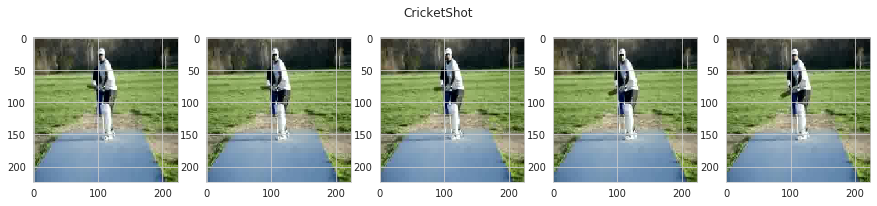

In [122]:
# Test the processing code
desc = get_data_descriptions('data_file.csv')
train_desc, test_desc = split_train_test(desc)
sample = train_desc[0]

raw_frames = get_frames_for_sample(sample)
frames = set_fixed_length(raw_frames, seq_length=50)
sequence = build_image_sequence(frames)

print(f'Length before: {len(raw_frames)}, Length after: {len(frames)}')

label = get_class_one_hot(classes, sample[1])
print(f'Class one-hot: {label}')

plot_sequences(sequence, classes[label.argmax()], n=5)

In [0]:
# Combine the processing code above into a generator
# We use make a thread safe generator to support multi-processing, so
# that training can be sped up if needed
# https://anandology.com/blog/using-iterators-and-generators/
# https://github.com/harvitronix/five-video-classification-methods/blob/master/data.py

import operator
import threading

class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

@threadsafe_generator
def frame_generator(data_file_path, classes, train_or_test, batch_size, seq_len):
    """Return a generator that we can use to train and validate.
    """
    desc = get_data_descriptions(data_file_path)
    train_desc, test_desc = split_train_test(desc)

    data = train_desc if train_or_test == 'train' else test_desc
    print(f'Creating {train_or_test} generator with {len(data)} samples')

    while 1:
      X, y = [], []

      # Generate batch_size samples
      for _ in range(batch_size):
          # Reset to be safe
          sequence = None

          # Get a random sample
          sample = random.choice(data)

          # Get frames
          raw_frames = get_frames_for_sample(sample)
          frames = set_fixed_length(raw_frames, seq_length=seq_len)

          # Build the image sequence
          sequence = build_image_sequence(frames)

          X.append(sequence)
          y.append(get_class_one_hot(classes, sample[1]))

          yield np.array(X), np.array(y)

Creating train generator with 212 samples
[[0. 0. 0. 0. 1.]]
(1, 30, 224, 224, 3)


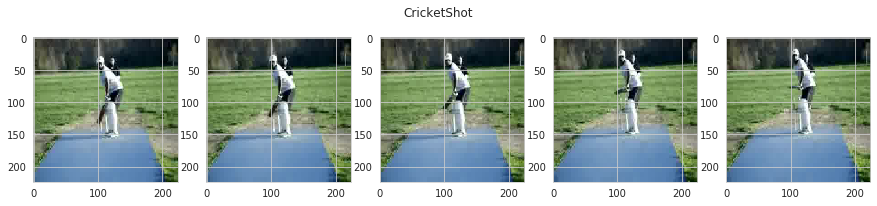

In [127]:
generator = frame_generator('data_file.csv', classes, 'train', batch_size=10,
                            seq_len=30)
X_batch, y_batch = next(generator)

print(y_batch)
print(X_batch.shape)

plot_sequences(X_batch[0], classes[y_batch[0].argmax()], n=5)